In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from matplotlib.pyplot import imshow
import tensorflow as tf
from tensorflow.keras import layers, models
import time

In [ ]:
no = "2"
dataPath = "/content/drive/MyDrive/ColabNotebooks/project/nifti"
imgs = { }
allBounds = {'w': 128, 'h': 128, 'd': 195}
def printImg(img):
    plt.imshow(img)
    plt.show()

In [ ]:
def createModel():
    # state
    lastInit = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    # input layer
    inputLayer = layers.Input(shape=([128, 128, 1]))
    # hidden layer
    hiddenLayer = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputLayer)
    hiddenLayer = layers.MaxPooling2D((2, 2))(hiddenLayer)
    hiddenLayer = layers.Conv2D(64, (3, 3), activation="relu")(hiddenLayer)
    hiddenLayer = layers.MaxPooling2D((2, 2))(hiddenLayer)
    hiddenLayer = layers.Conv2D(64, (3, 3), activation="relu")(hiddenLayer)
    hiddenLayer = layers.Flatten()(hiddenLayer)
    hiddenLayer = layers.Dense(200, activation="relu")(hiddenLayer)
    # output layer
    outputLayer = layers.Dense(100, activation="sigmoid", kernel_initializer=lastInit)(hiddenLayer)
    outputLayer = outputLayer * 1
    model = tf.keras.Model(inputLayer, outputLayer)
    return model
m = createModel()
m.summary()

In [ ]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = layers.ConvLSTM2D(n_filters, kernel_size = (3, 3), padding = "same", activation = "relu", return_sequences=True, kernel_initializer = "he_normal")(x)
    print(x)
    # Conv2D then ReLU activation
    x = layers.ConvLSTM2D(n_filters, kernel_size = (3, 3), padding = "same", activation = "relu", return_sequences=True, kernel_initializer = "he_normal")(x)
    return x
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool3D(pool_size=(2, 2, 2))(f)
    p = layers.Dropout(0.2)(p)
    return f, p
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv3DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.2)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x
def build_unet_model(inX, inY):
    # inputs
    inputs = layers.Input(shape=(8, inX, inY, 1))
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    # f4, p4 = downsample_block(p3, 512)
    # 5 - bottleneck
    bottleneck = double_conv_block(p3, 1024)
    # decoder: expanding path - upsample
    # 6 - upsample
    # u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(bottleneck, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model
unet_model = build_unet_model(128, 128)
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")
unet_model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 1, 16, 16, 1024), dtype=tf.float32, name=None), name='conv_lstm2d_32/transpose_1:0', description="created by layer 'conv_lstm2d_32'")
KerasTensor(type_spec=TensorSpec(shape=(None, 2, 32, 32, 256), dtype=tf.float32, name=None), name='conv_lstm2d_34/transpose_1:0', description="created by layer 'conv_lstm2d_34'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 64, 64, 128), dtype=tf.float32, name=None), name='conv_lstm2d_36/transpose_1:0', description="created by layer 'conv_lstm2d_36'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 128, 128, 64), dtype=tf.float32, name=None), name='conv_lstm2d_38/transpose_1:0', description="created by layer 'conv_lstm2d_38'")
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 8, 128, 128  0           []  

In [ ]:
def readImgBound(no):
    global dataPath
    f = open('{}/{}/ranges.txt'.format(dataPath, no), "r")
    lines = f.readlines()
    valRange = [float(i) for i in (lines[0].split("(")[1].split(")")[0].split(" to "))]
    bounds = lines[1].split("; ")
    xs = [int(i) for i in bounds[0].split(": ")[1].split(")")[0].split(", ")]
    ys = [int(i) for i in bounds[1].split(": ")[1].split(")")[0].split(", ")]
    zs = [int(i) for i in bounds[2].split(": ")[1].split(")")[0].split(", ")]
    return { 'x0': xs[0], 'x1': xs[1], 'y0': ys[0], 'y1': ys[1], 'b': zs[0], 't': zs[1], 'z0': zs[0], 'z1': zs[1], 'width': xs[1] - xs[0], 'height': ys[1] - ys[0], 'depth': zs[1] - zs[0], "val0": valRange[0], "val1": valRange[1] }


imgsX = np.load("{}/0_range/organ3/x-real-{}-{}-128x128x1-skip0.npy".format(dataPath, 1, 100))
imgsY = np.load("{}/0_range/organ3/y-border-{}-{}-128x128x3-skip0.npy".format(dataPath, 1, 100))
imgD = [ ]
imgY = [ ]
def getXYVals(noFrom, noTo):
    global imgD, imgY, imgsX, imgsY
    imgD = [ ]
    imgY = [ ]
    c = 0
    for no in range(1, noFrom):
        c = c + readImgBound(no)["depth"]
    for no in range(noFrom, noTo):
        noL = readImgBound(no)["depth"]
        for z in range(8, noL):
            imgDt = [ ]
            imgYt = [ ]
            for zs in range(z - 8, z):
                imgDt.append(imgsX[c + zs])
                imgYt.append(imgsY[c + zs])
            imgD.append(imgDt)
            imgY.append(imgYt)
        c = c + noL
    imgD = np.array(imgD)
    imgY = np.array(imgY)

In [ ]:
getXYVals(1, 10)
print(imgD.shape)
print(imgY.shape)

(270, 8, 128, 128, 1)
(270, 8, 128, 128, 1)


In [ ]:
res = unet_model.fit(imgD, imgY, epochs=4)

normal unet skip 8

In [ ]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x
def build_unet_model(inX, inY):
    # inputs
    inputs = layers.Input(shape=(inX, inY, 8))
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model
unet_model = build_unet_model(128, 128)
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

In [ ]:
def readImgBound(no):
    global dataPath
    f = open('{}/{}/ranges.txt'.format(dataPath, no), "r")
    lines = f.readlines()
    valRange = [float(i) for i in (lines[0].split("(")[1].split(")")[0].split(" to "))]
    bounds = lines[1].split("; ")
    xs = [int(i) for i in bounds[0].split(": ")[1].split(")")[0].split(", ")]
    ys = [int(i) for i in bounds[1].split(": ")[1].split(")")[0].split(", ")]
    zs = [int(i) for i in bounds[2].split(": ")[1].split(")")[0].split(", ")]
    return { 'x0': xs[0], 'x1': xs[1], 'y0': ys[0], 'y1': ys[1], 'b': zs[0], 't': zs[1], 'z0': zs[0], 'z1': zs[1], 'width': xs[1] - xs[0], 'height': ys[1] - ys[0], 'depth': zs[1] - zs[0], "val0": valRange[0], "val1": valRange[1] }


imgsX = np.load("{}/0_range/organ3/x-real-{}-{}-128x128x1-skip0.npy".format(dataPath, 1, 100))
imgsY = np.load("{}/0_range/organ3/y-border-{}-{}-128x128x3-skip0.npy".format(dataPath, 1, 100))
imgD = [ ]
imgY = [ ]
def getXYVals(noFrom, noTo):
    global imgD, imgY, imgsX, imgsY
    imgD = [ ]
    imgY = [ ]
    c = 0
    for no in range(1, noFrom):
        c = c + readImgBound(no)["depth"]
    for no in range(noFrom, noTo):
        noL = readImgBound(no)["depth"]
        for z in range(8, noL):
            imgDt = [[[ ] for i in range(128)] for j in range(128)]
            for i in range(128):
                for j in range(128):
                    for zs in range(z - 8, z):
                        imgDt[i][j].append(imgsX[c + zs][i][j][0])
            imgD.append(imgDt)
            imgY.append(imgsY[z - 1])
        c = c + noL
    imgD = np.array(imgD)
    imgY = np.array(imgY)

In [ ]:
tnn1 = 30

In [ ]:
tnn2 = tnn1 + 10
getXYVals(tnn1, tnn2)
print(imgD.shape)
print(imgY.shape)
print(tnn1, tnn2)
tnn1 = tnn2

(224, 128, 128, 8)
(224, 128, 128, 1)
90 100


In [ ]:
res = unet_model.fit(imgD, imgY, epochs=2)

Epoch 1/4
34/34 [==============================] - 10s 282ms/step - loss: 0.3850 - accuracy: 0.8706
Epoch 2/4
34/34 [==============================] - 8s 240ms/step - loss: 0.3629 - accuracy: 0.8714
Epoch 3/4
34/34 [==============================] - 8s 240ms/step - loss: 0.3436 - accuracy: 0.8720
Epoch 4/4
34/34 [==============================] - 8s 240ms/step - loss: 0.3281 - accuracy: 0.8731


test

In [ ]:
def readImgBound(no):
    global dataPath
    f = open('{}/{}/ranges.txt'.format(dataPath, no), "r")
    lines = f.readlines()
    valRange = [float(i) for i in (lines[0].split("(")[1].split(")")[0].split(" to "))]
    bounds = lines[1].split("; ")
    xs = [int(i) for i in bounds[0].split(": ")[1].split(")")[0].split(", ")]
    ys = [int(i) for i in bounds[1].split(": ")[1].split(")")[0].split(", ")]
    zs = [int(i) for i in bounds[2].split(": ")[1].split(")")[0].split(", ")]
    return { 'x0': xs[0], 'x1': xs[1], 'y0': ys[0], 'y1': ys[1], 'b': zs[0], 't': zs[1], 'z0': zs[0], 'z1': zs[1], 'width': xs[1] - xs[0], 'height': ys[1] - ys[0], 'depth': zs[1] - zs[0], "val0": valRange[0], "val1": valRange[1] }


imgsXTest = np.load("{}/0_range/organ3/x-real-{}-{}-128x128x1-skip0.npy".format(dataPath, 100, 110))
imgsYTest = np.load("{}/0_range/organ3/y-border-{}-{}-128x128x3-skip0.npy".format(dataPath, 100, 110))
imgDTest = [ ]
imgYTest = [ ]
def getXYTestVals(noFrom, noTo):
    global imgDTest, imgYTest, imgsXTest, imgsYTest
    imgDTest = [ ]
    imgYTest = [ ]
    c = 0
    for no in range(100, noFrom):
        c = c + readImgBound(no)["depth"]
    for no in range(noFrom, noTo):
        noL = readImgBound(no)["depth"]
        for z in range(8, noL):
            imgDt = [[[ ] for i in range(128)] for j in range(128)]
            for i in range(128):
                for j in range(128):
                    for zs in range(z - 8, z):
                        imgDt[i][j].append(imgsXTest[c + zs][i][j][0])
            imgDTest.append(imgDt)
            imgYTest.append(imgsYTest[z - 1])
        c = c + noL
    imgDTest = np.array(imgDTest)
    imgYTest = np.array(imgYTest)

In [ ]:
getXYTestVals(100, 110)
print(imgDTest.shape)
print(imgYTest.shape)

(283, 128, 128, 8)
(283, 128, 128, 1)


In [ ]:
def predY(no):
    c = 0
    for n in range(100, no):
        c = c + readImgBound(n)["depth"] - 8
    noL = readImgBound(no)["depth"]
    for z in range(8, noL):
        imgDts = imgDTest[c].copy()
        imgDts = imgDts.reshape((1, 128, 128, 8))
        imgPredts = unet_model.predict(imgDts)
        printImg(imgPredts.reshape((128, 128, 3)))
        imgYts = imgYTest[c].copy()
        printImg(imgYts.reshape((128, 128)))
        print("------", c)
        c = c + 1
predY(100)

normal unet

In [ ]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = layers.Conv3D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv3D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool3D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv3DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x
def build_unet_model(inX, inY, inZ):
    # inputs
    inputs = layers.Input(shape=(inZ, inX, inY, 1))
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
    # outputs
    outputs = layers.Conv3D(3, 1, padding="same", activation = "softmax")(u9)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model
unet_model2 = build_unet_model(128, 128, 128)
unet_model2.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")
unet_model2.summary()

In [ ]:
imgD = np.load("{}/0_range/organ3/x-real-{}-{}-128x128x1-skip0.npy".format(dataPath, 1, 100))
imgY = np.load("{}/0_range/organ3/y-border-{}-{}-128x128x3-skip0.npy".format(dataPath, 1, 100))
print(imgD.shape)
print(imgY.shape)

(3859, 128, 128, 1)
(3859, 128, 128, 1)


In [ ]:
def get3D():
    c = 0
    retImgD = [ ]
    retImgY = [ ]
    for n in range(100, no):
        c = c + readImgBound(n)["depth"]
    noL = readImgBound(no)["depth"]
    for z in range(0, noL):
        imgDts = imgDTest[c].copy()
        imgDts = imgDts.reshape((1, 128, 128, 1))
        imgPredts = unet_model2.predict(imgDts)
        printImg(imgPredts.reshape((128, 128, 3)))
        imgYts = imgYTest[c].copy()
        printImg(imgYts.reshape((128, 128)))
        print("------", c)
        c = c + 1
predY(101)

In [ ]:
res = unet_model2.fit(imgD, imgY, epochs=90)

Epoch 1/90
121/121 [==============================] - 32s 248ms/step - loss: 10.4968 - accuracy: 0.8238
Epoch 2/90
121/121 [==============================] - 29s 236ms/step - loss: 0.3825 - accuracy: 0.9015
Epoch 3/90
121/121 [==============================] - 29s 236ms/step - loss: 0.2279 - accuracy: 0.9284
Epoch 4/90
121/121 [==============================] - 29s 236ms/step - loss: 0.1846 - accuracy: 0.9373
Epoch 5/90
121/121 [==============================] - 29s 236ms/step - loss: 0.1643 - accuracy: 0.9418
Epoch 6/90
121/121 [==============================] - 29s 236ms/step - loss: 0.1534 - accuracy: 0.9459
Epoch 7/90
121/121 [==============================] - 29s 236ms/step - loss: 0.1391 - accuracy: 0.9516
Epoch 8/90
121/121 [==============================] - 29s 237ms/step - loss: 0.1269 - accuracy: 0.9553
Epoch 9/90
121/121 [==============================] - 29s 237ms/step - loss: 0.1273 - accuracy: 0.9556
Epoch 10/90
121/121 [==============================] - 29s 236ms/step - 

In [ ]:
unet_model2.save("{}/0_range/organ3/{}-{}-128x128x1-128x128x3-skip0".format(dataPath, 1, 100))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ColabNotebooks/project/nifti/0_range/organ3/1-100-128x128x1-128x128x3-skip0/assets


In [ ]:
imgDTest = np.load("{}/0_range/organ3/x-real-{}-{}-128x128x1-skip0.npy".format(dataPath, 100, 110))
imgYTest = np.load("{}/0_range/organ3/y-border-{}-{}-128x128x3-skip0.npy".format(dataPath, 100, 110))

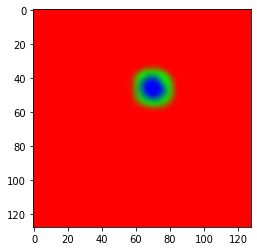

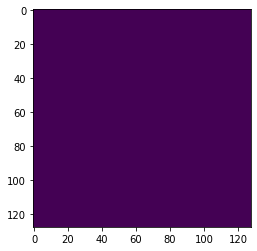

------ 31


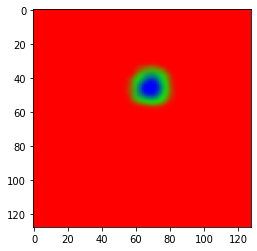

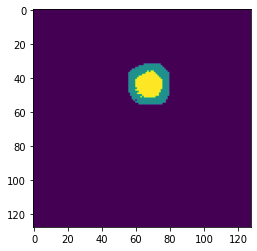

------ 32


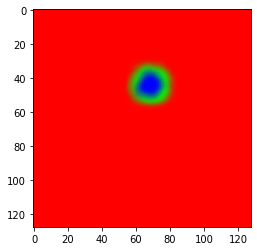

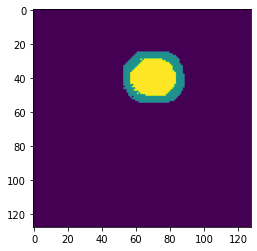

------ 33


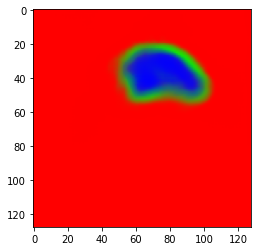

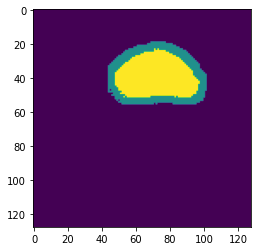

------ 34


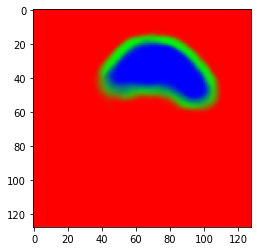

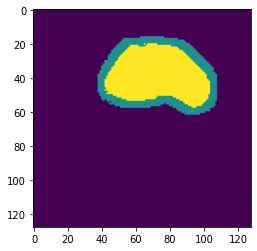

------ 35


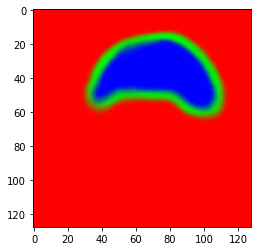

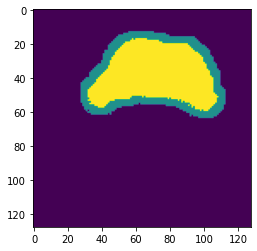

------ 36


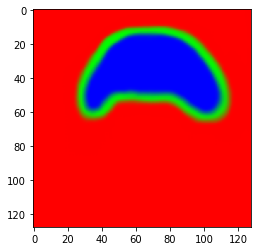

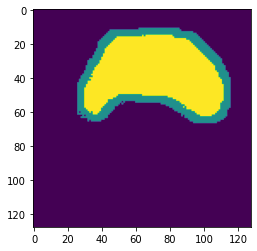

------ 37


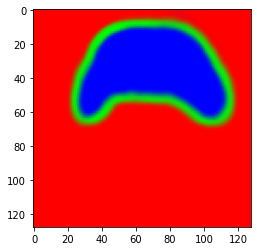

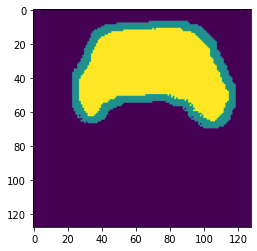

------ 38


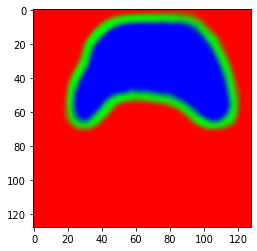

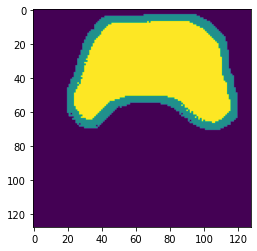

------ 39


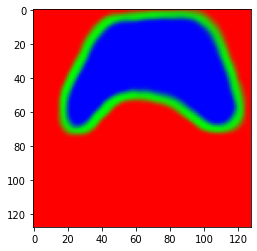

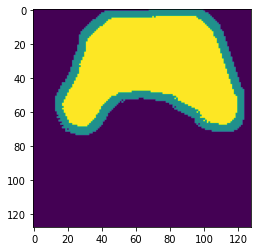

------ 40


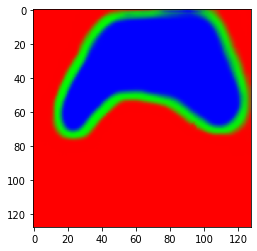

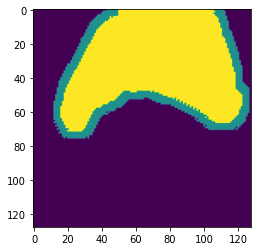

------ 41


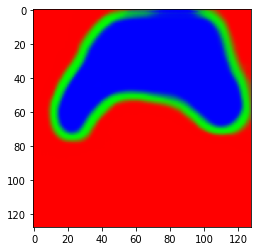

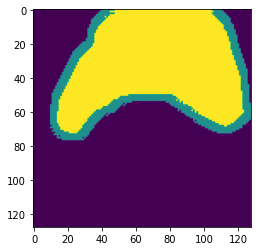

------ 42


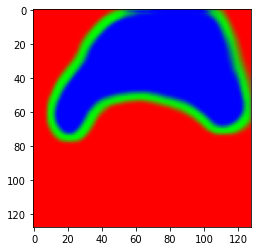

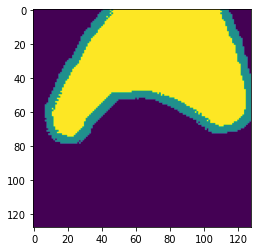

------ 43


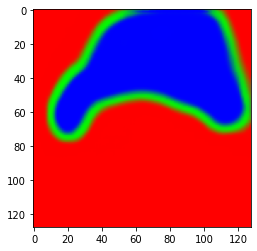

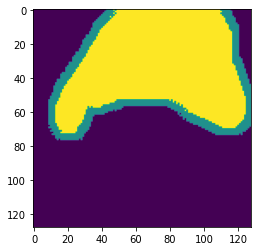

------ 44


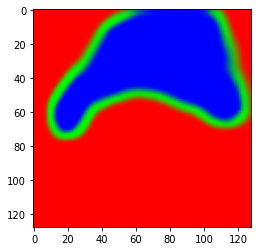

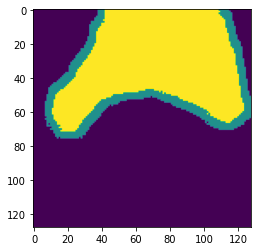

------ 45


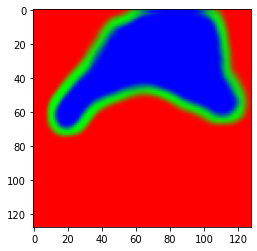

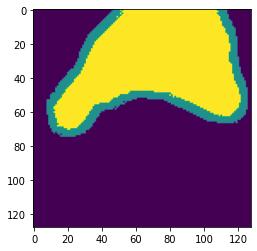

------ 46


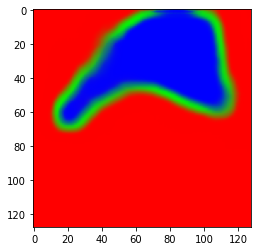

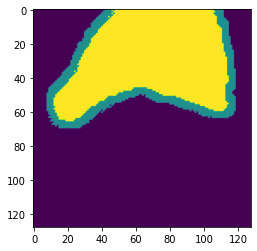

------ 47


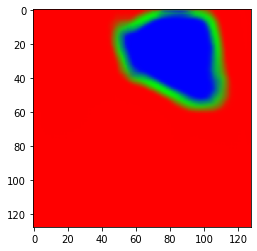

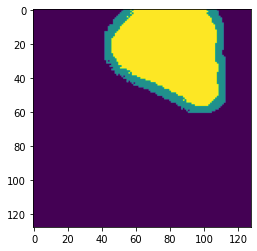

------ 48


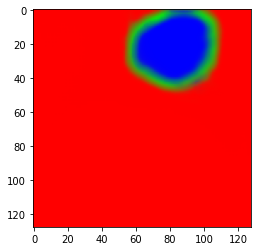

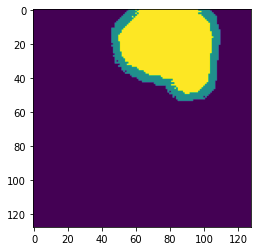

------ 49


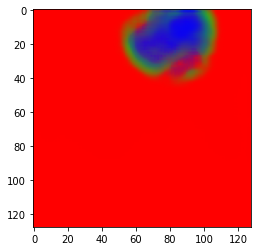

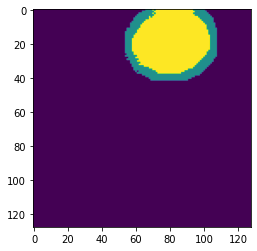

------ 50


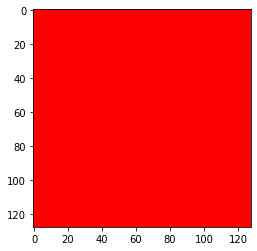

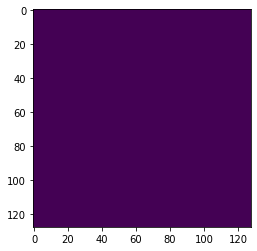

------ 51


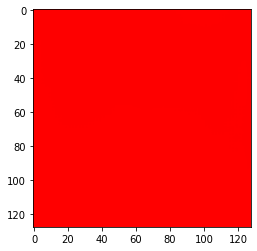

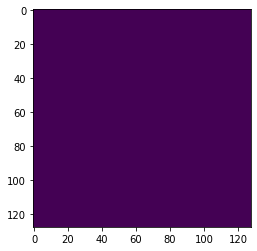

------ 52


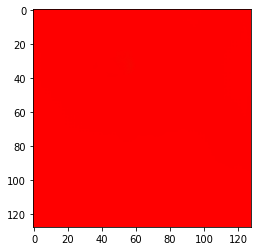

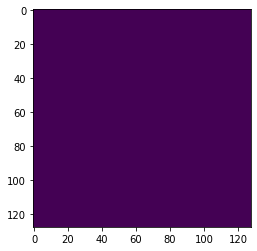

------ 53


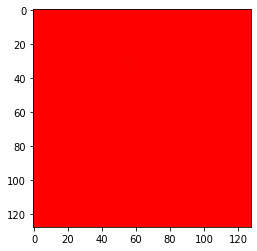

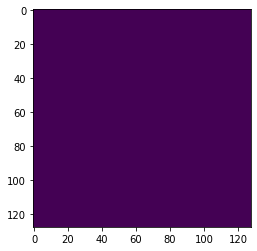

------ 54


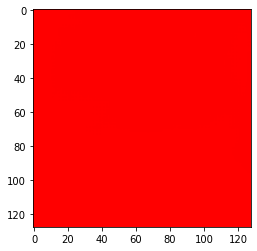

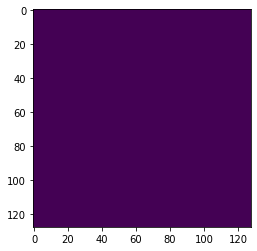

------ 55


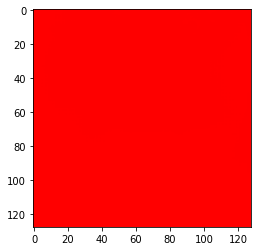

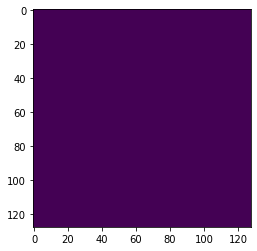

------ 56


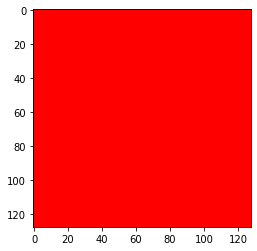

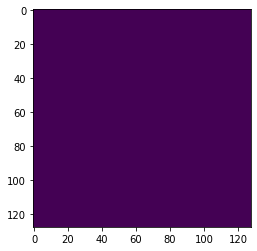

------ 57


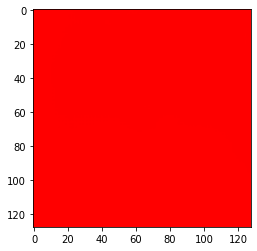

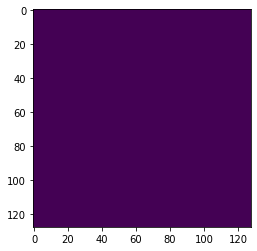

------ 58


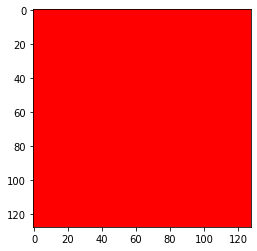

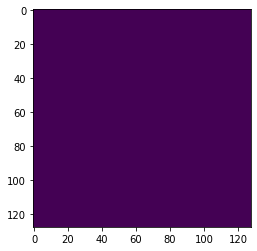

------ 59


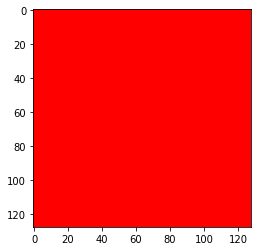

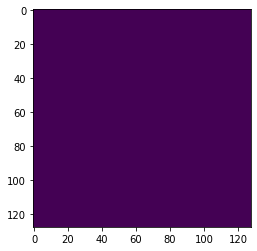

------ 60


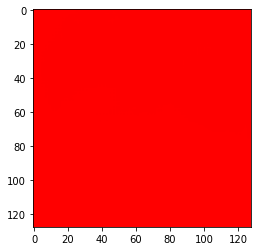

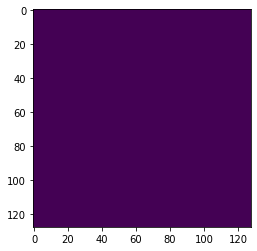

------ 61


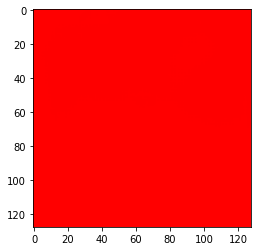

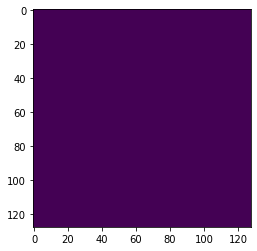

------ 62


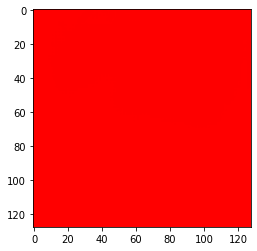

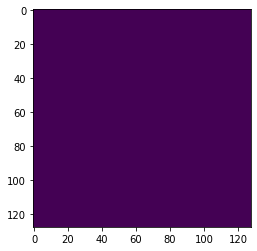

------ 63


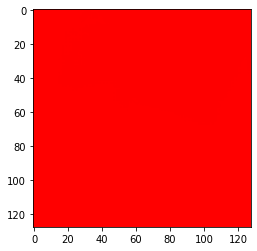

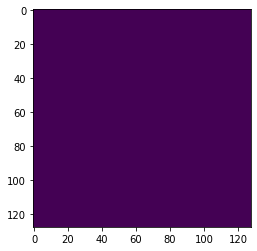

------ 64


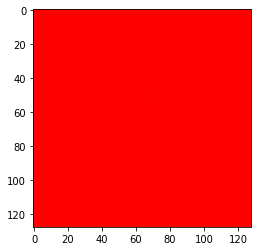

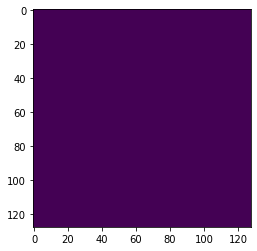

------ 65


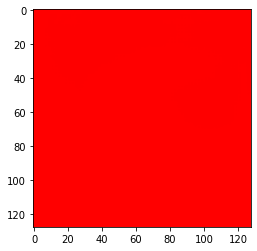

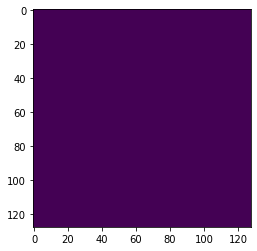

------ 66


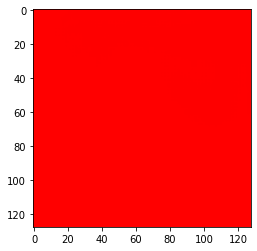

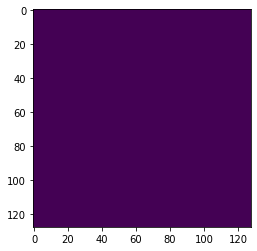

------ 67


In [ ]:
def predY(no):
    c = 0
    for n in range(100, no):
        c = c + readImgBound(n)["depth"]
    noL = readImgBound(no)["depth"]
    for z in range(0, noL):
        imgDts = imgDTest[c].copy()
        imgDts = imgDts.reshape((1, 128, 128, 1))
        imgPredts = unet_model2.predict(imgDts)
        printImg(imgPredts.reshape((128, 128, 3)))
        imgYts = imgYTest[c].copy()
        printImg(imgYts.reshape((128, 128)))
        print("------", c)
        c = c + 1
predY(101)